In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)
mnist.data.shape

(70000, 784)

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np


X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X = np.concatenate([X[np.where(y==0)[0]], X[np.where(y==1)[0]]], axis=0)
y = np.concatenate([np.zeros(sum(y==0)), np.ones(sum(y==1))], axis=0)


X = X / 255.0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)


# define the batch loader of the dataset
def batch_loader(X, y, batch, shuffle=True):
    num_samples = len(X)
    pointer = 0
    while True:
        if shuffle:
            idx = np.random.choice(num_samples, batch)
        else:
            if pointer + batch <= num_samples:
                idx = np.arange(pointer, pointer+batch)
                pointer = pointer + batch
            else:
                pointer = 0
                idx = np.arange(pointer, pointer+batch)
                pointer = pointer + batch
        yield X[idx], y[idx]

X train shape (11824, 784)
y train shape (11824,)


In [4]:
import copy

class operator(object):
    """
    Operator abstraction
    """

    def forward(self, input):
        """Forward operator, reture output from this operator"""
        raise NotImplementedError

    def backward(self, out_grad, input):
        """Backward operator, return gradient to input"""
        raise NotImplementedError


class matmul(operator):
    def __init__(self):
        super(matmul, self).__init__()

    def forward(self, input, weights):
        """
        # Arguments
            input: numpy array with shape (batch, in_features)
            weights: numpy array with shape (in_features, out_features)

        # Returns
            output: numpy array with shape(batch, out_features)
        """
        return np.matmul(input, weights)

    def backward(self, out_grad, input, weights):
        """
        # Arguments
            out_grad: gradient to the forward output of fc layer, with shape (batch, out_features)
            input: numpy array with shape (batch, in_features)
            weights: numpy array with shape (in_features, out_features)

        # Returns
            in_grad: gradient to the forward input with same shape as input
            w_grad: gradient to weights, with same shape as weights            
        """
        in_grad = np.matmul(out_grad, weights.T)
        w_grad = np.matmul(input.T, out_grad)
        return in_grad, w_grad


class add_bias(operator):
    def __init__(self):
        super(add_bias, self).__init__()

    def forward(self, input, bias):
        '''TODO
        # Arugments
          input: numpy array with shape (batch, in_features)
          bias: numpy array with shape (in_features)

        # Returns
          output: numpy array with shape(batch, in_features)
        '''
        return input+bias

    def backward(self, out_grad, input, bias):
        """TODO
        # Arguments
            out_grad: gradient to the forward output of fc layer, with shape (batch, out_features)
            input: numpy array with shape (batch, in_features)
            bias: numpy array with shape (out_features)
        # Returns
            in_grad: gradient to the forward input with same shape as input
            b_bias: gradient to bias, with same shape as bias
        """
        in_grad = np.matmul(out_grad,np.ones((out_grad.shape[-1],input.shape[-1])))
        b_grad = np.matmul(out_grad.T,np.ones(out_grad.shape[0]))
        
        return in_grad, b_grad


class relu(operator):
    def __init__(self):
        super(relu, self).__init__()

    def forward(self, input):
        """TODO"""
        mask = np.where(input>0,1,0)
        output = input*mask
        return output

    def backward(self, out_grad, input):
        """TODO"""
        mask = np.where(input>0,1,0)
        in_grad = out_grad*mask
        return in_grad


class softmax_cross_entropy(operator):
    def __init__(self):
        super(softmax_cross_entropy, self).__init__()

    def forward(self, input, labels):
        """
        # Arguments
            input: numpy array with shape (batch, num_class)
            labels: numpy array with shape (batch,)
            eps: float, precision to avoid overflow

        # Returns
            output: scalar, average loss
            probs: the probability of each category
        """
        # precision to avoid overflow
        eps = 1e-12
        batch = len(labels)
        labels = labels.astype('int')
        # convert labels into a matrix format
        y = np.zeros(input.shape)
        y[np.arange(batch), labels]=1

        input_shift = input - np.max(input, axis=1, keepdims=True)
        Z = np.sum(np.exp(input_shift), axis=1, keepdims=True)

        log_probs = input_shift - np.log(Z+eps)
        probs = np.exp(log_probs)
        output = -1 * np.sum(log_probs * y) / batch
        return output, probs

    def backward(self, input, labels):
        """
        # Arguments
            input: numpy array with shape (batch, num_class)
            labels: numpy array with shape (batch,)
            eps: float, precision to avoid overflow

        # Returns
            in_grad: gradient to forward input of softmax cross entropy, with shape (batch, num_class)
        """
        # precision to avoid overflow
        eps = 1e-12
        batch = len(labels)
        labels = labels.astype('int')
        y = np.zeros(input.shape)
        y[np.arange(batch), labels]=1

        input_shift = input - np.max(input, axis=1, keepdims=True)
        Z = np.sum(np.exp(input_shift), axis=1, keepdims=True)
        log_probs = input_shift - np.log(Z+eps)
        probs = np.exp(log_probs)

        in_grad = probs-y

        """TODO compute the in_grad"""
        return in_grad

In [5]:
class optimizer():

    def __init__(self, lr):
        """Initialization

        # Arguments
            lr: float, learnig rate 
        """
        self.lr = lr

    def update(self, x, x_grad, iteration):
        """Update parameters with gradients"""
        raise NotImplementedError

  

class SGD(optimizer):

    def __init__(self, lr=0.01, momentum=0):
        """Initialization

        # Arguments
            lr: float, learnig rate 
            momentum: float, the ratio of moments            
        """
        super(SGD, self).__init__(lr)
        self.momentum = momentum
        self.moments = None         
        

    def update(self, xs, xs_grads, iteration):
        """Initialization

        # Arguments
            xs: dictionary, all weights of model
            xs_grads: dictionary, gradients to all weights of model, same keys with xs
            iteration: int, current iteration number in the whole training process (not in that epoch)

        # Returns
            new_xs: dictionary, new weights of model
        """
        new_xs = {}        
        if not self.moments:
            self.moments = {}
            for k, v in xs_grads.items():
                self.moments[k] = np.zeros(v.shape)        
        for k in list(xs.keys()):
            """TODO update the parameter based on the gradient and momentum"""
            new_xs[k] = xs[k]-self.lr*xs_grads[k]
        return new_xs

In [6]:
class simple_classifier():

    def __init__(self, n_in, n_out1, n_out2):
        """Initialization

        # Arguments
            n_in: the number of input features
            n_out1: the output features of first fully connected layer
            n_out2: the output features of first fully connected layer

        # Returns
            new_xs: dictionary, new weights of model
        """
        self.matmul = matmul()
        self.add_bias = add_bias()
        self.relu = relu()
        self.softmax_cross_entropy = softmax_cross_entropy()

        # initialize parameters
        self.w1 = np.random.normal(loc=0.0, scale=0.1, size=(n_in, n_out1))
        self.b1 = np.random.normal(loc=0.0, scale=0.1, size=(n_out1, ))
        
        # TODO initialize w2 and b2
        self.w2 = np.random.normal(loc=0.0, scale=0.1, size=(n_out1, n_out2))
        self.b2 = np.random.normal(loc=0.0, scale=0.1, size=(n_out2, ))
        
        # cacehs to save intermedia results of forward
        self.caches = []

    def accuracy(self, probs, target):
        # probs: probability that each image is labeled as 1
        # target: ground truth label
        
        prediction = probs.argmax(axis=-1)    
        acc = np.mean(prediction == target)
        return acc * 100


    def get_params(self):

        param_dict = {
            'w1': self.w1,
            'b1': self.b1,
            'w2': self.w2,
            'b2': self.b2,
        }
        return param_dict


    def forward(self, X, y):
        # compute the accuracy and loss

        caches = [X] # to save intermedia results for backward pass
        
        # layer 1
        out1 = self.matmul.forward(X, self.w1)
        caches += [out1]
        out1 = self.add_bias.forward(out1, self.b1)
        caches += [out1]
        out1 = self.relu.forward(out1)
        caches += [out1]


        # layer 2
        out2 = self.matmul.forward(out1, self.w2)
        caches += [out2]
        out2 = self.add_bias.forward(out2, self.b2)
        caches += [out2]


        self.caches = caches

        # loss
        loss, probs = self.softmax_cross_entropy.forward(out2, y)
        acc = self.accuracy(probs, y)  

        return acc, loss

    def backward(self, X, y):


        # loss backward
        inp = self.caches.pop()
        in_grad = self.softmax_cross_entropy.backward(inp, y)

        # TODO layer 2 backward
        in_grad1,b2_grad = self.add_bias.backward(in_grad,self.caches.pop(),self.b2)
        in_grad2,w2_grad = self.matmul.backward(in_grad,self.caches.pop(),self.w2)
        relu_grad = self.relu.backward(in_grad2,self.caches.pop())

        
        # TODO layer 1 backward
        in_grad1,b1_grad = self.add_bias.backward(relu_grad,self.caches.pop(),self.b1)
        in_grad2,w1_grad = self.matmul.backward(relu_grad,self.caches.pop(),self.w1)
        
        grad_dict = {
            'w1': w1_grad,
            'b1': b1_grad,
            'w2': w2_grad,
            'b2': b2_grad,
        }

        return grad_dict

    
    def update(self, new_param_dict):
        self.w1 = new_param_dict['w1']
        self.b1 = new_param_dict['b1']
        self.w2 = new_param_dict['w2']
        self.b2 = new_param_dict['b2']

In [7]:
# hyper-parameters
batch = 32
log_freq = 50 # log-printing frequency
batches_of_epoch = len(X_train) // batch
epochs = 20

data_loader = batch_loader(X_train, y_train, batch, shuffle=False)
model = simple_classifier(n_in=784, n_out1=120, n_out2=2)
sgd = SGD(lr=0.0001) #, momentum=0.8)

metrics = [] # to store intermediate results during optimization

for i in range(epochs):
    print(f"==> epoch {i+1}")
    
    sum_train_acc, sum_train_loss = 0, 0

    for itr in range(batches_of_epoch):
        # get batch of data
        X_train_b, y_train_b = next(data_loader)

        params = model.get_params()
        train_acc, train_loss = model.forward(X_train_b, y_train_b)
        grads = model.backward(X_train_b, y_train_b)
        new_params = sgd.update(params, grads, itr)
        model.update(new_params)

        sum_train_acc += train_acc
        sum_train_loss += train_loss

        if itr % log_freq == 0:
            print("\t iter %d \t train acc = %.2f%%, train loss = %.4f" %(itr, train_acc, train_loss))

    avg_train_acc, avg_train_loss = sum_train_acc / batches_of_epoch, sum_train_loss / batches_of_epoch

    test_acc, test_loss = model.forward(X_test, y_test)
    print("\t avg train acc = %.2f%%, avg train loss = %.4f | test acc = %.2f%%, test loss = %.4f" 
          % (avg_train_acc, avg_train_loss, test_acc, test_loss))
        
    metrics += [[avg_train_acc, avg_train_loss, test_acc, test_loss]] # to store intermediate results

==> epoch 1
	 iter 0 	 train acc = 62.50%, train loss = 0.6861
	 iter 50 	 train acc = 96.88%, train loss = 0.2724
	 iter 100 	 train acc = 100.00%, train loss = 0.1248
	 iter 150 	 train acc = 100.00%, train loss = 0.1229
	 iter 200 	 train acc = 100.00%, train loss = 0.0844
	 iter 250 	 train acc = 100.00%, train loss = 0.0758
	 iter 300 	 train acc = 96.88%, train loss = 0.1098
	 iter 350 	 train acc = 96.88%, train loss = 0.0789
	 avg train acc = 98.19%, avg train loss = 0.1383 | test acc = 99.29%, test loss = 0.0580
==> epoch 2
	 iter 0 	 train acc = 100.00%, train loss = 0.0452
	 iter 50 	 train acc = 100.00%, train loss = 0.0484
	 iter 100 	 train acc = 100.00%, train loss = 0.0313
	 iter 150 	 train acc = 100.00%, train loss = 0.0422
	 iter 200 	 train acc = 100.00%, train loss = 0.0327
	 iter 250 	 train acc = 100.00%, train loss = 0.0323
	 iter 300 	 train acc = 96.88%, train loss = 0.0794
	 iter 350 	 train acc = 100.00%, train loss = 0.0509
	 avg train acc = 99.45%, avg tra

	 iter 150 	 train acc = 100.00%, train loss = 0.0052
	 iter 200 	 train acc = 100.00%, train loss = 0.0031
	 iter 250 	 train acc = 100.00%, train loss = 0.0040
	 iter 300 	 train acc = 100.00%, train loss = 0.0191
	 iter 350 	 train acc = 100.00%, train loss = 0.0111
	 avg train acc = 99.79%, avg train loss = 0.0074 | test acc = 99.76%, test loss = 0.0106
==> epoch 18
	 iter 0 	 train acc = 100.00%, train loss = 0.0032
	 iter 50 	 train acc = 100.00%, train loss = 0.0045
	 iter 100 	 train acc = 100.00%, train loss = 0.0019
	 iter 150 	 train acc = 100.00%, train loss = 0.0050
	 iter 200 	 train acc = 100.00%, train loss = 0.0029
	 iter 250 	 train acc = 100.00%, train loss = 0.0038
	 iter 300 	 train acc = 100.00%, train loss = 0.0180
	 iter 350 	 train acc = 100.00%, train loss = 0.0106
	 avg train acc = 99.80%, avg train loss = 0.0072 | test acc = 99.80%, test loss = 0.0103
==> epoch 19
	 iter 0 	 train acc = 100.00%, train loss = 0.0030
	 iter 50 	 train acc = 100.00%, train loss

(20, 4)


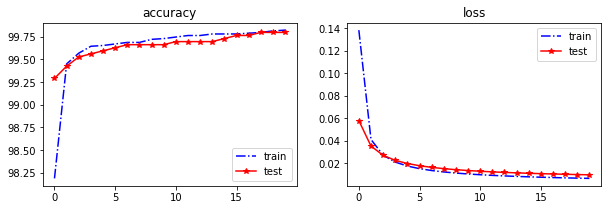

In [8]:
metrics = np.array(metrics)
print(metrics.shape)

epochs = len(metrics)
x = range(epochs)


plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title('accuracy')
plt.plot(x, metrics[:,0], 'b-.', label='train')
plt.plot(x, metrics[:,2], 'r-*', label='test')
plt.legend()

plt.subplot(122)
plt.title('loss')
plt.plot(x, metrics[:,1], 'b-.', label='train')
plt.plot(x, metrics[:,3], 'r-*', label='test')
plt.legend()
plt.show()